# ポアソン分布の学習と予測

### ポアソン分布の学習と予測：実装のための要点

ポアソン分布は「単位時間あたりに平均λ回起こる事象が、実際にx回起こる確率」をモデル化します。例えば、1時間あたりのウェブサイトへのアクセス数や、1日あたりのメール受信数などです。

-----

### シナリオとPythonサンプルコード

**シナリオ**:
あるカフェのオーナーが、平日の午後（1時間）に来店する**お客さんの平均人数 `λ`** を知りたいと考えています。過去の経験から「たぶん1時間に5人くらいかな…」とぼんやり考えていますが、不確かです。そこで、実際に20日間のお客さんの数を記録して、`λ` をより正確に推定し、明日の来店客数を予測します。

  * **真の平均 (`λ_true`)**: お客さんが来店する真の平均は **1時間あたり8人** とします（この値はオーナーには未知）。
  * **事前分布**: オーナーの「たぶん5人くらい」という曖昧な信念を、平均が5 (`a/b=5`) で分散が大きめ（不確実性が高い）のガンマ分布 `Gam(λ|a=5, b=1)` で表現します。


観測データ (日ごとの来店客数):
[14  8  8  8  6  6  5  7  7  4  9  6 13 12  8 14  8  9  3  6]


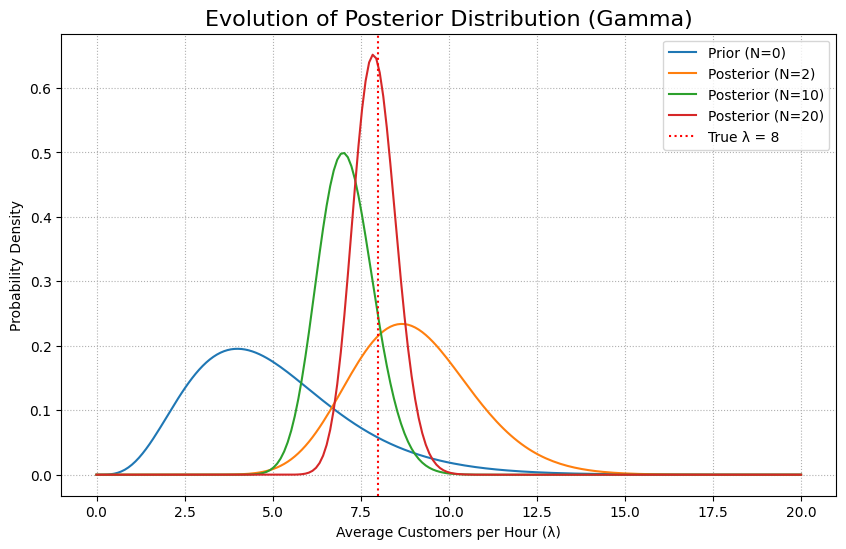

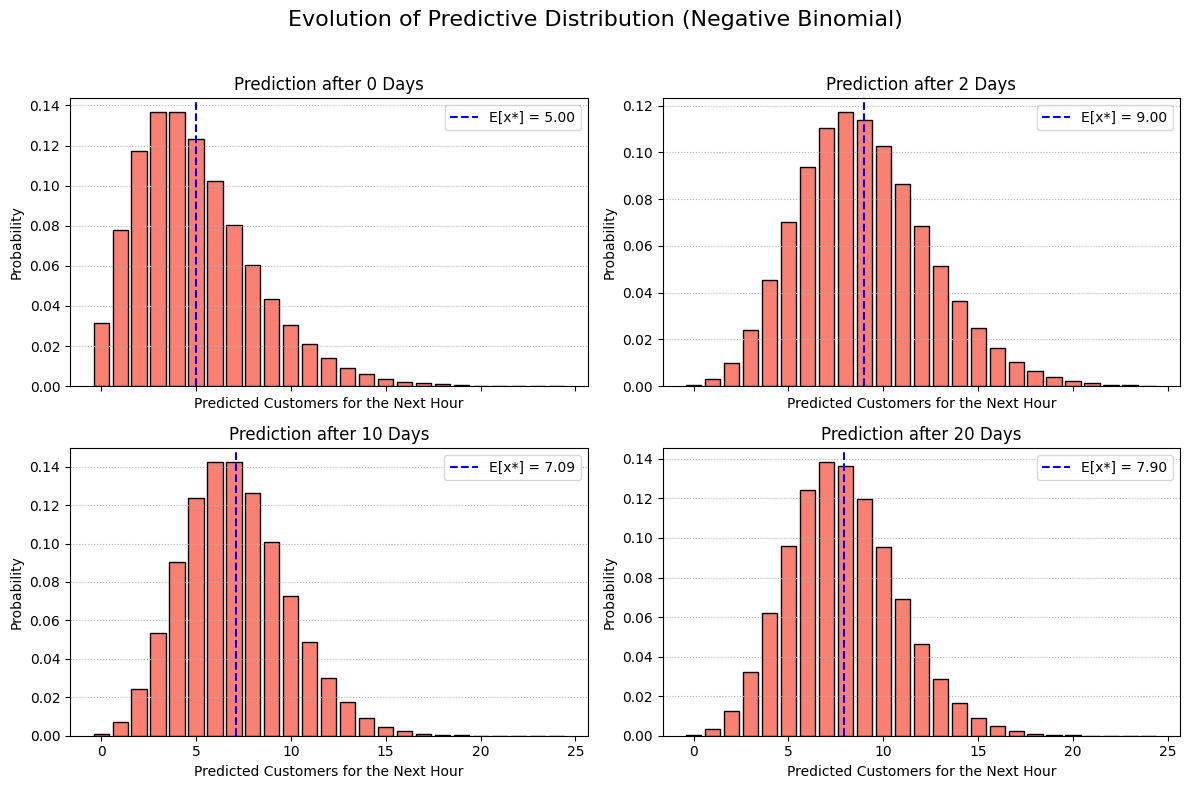

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, nbinom

# --- 1. シナリオ設定 ---
# 1時間あたりの来店客数の「真の」平均
lambda_true = 8

# 事前分布のハイパーパラメータ Gam(a, b)
# 平均 a/b=5, 分散 a/b^2=5 で「5人くらい」という曖昧な信念を表現
a_prior = 5
b_prior = 1

# 観測日数
num_days = 20

# 20日間の来店客数をシミュレーション
np.random.seed(0)
data = np.random.poisson(lam=lambda_true, size=num_days)
print(f"観測データ (日ごとの来店客数):\n{data}")

# --- 2. 特定の時点での分布を計算 ---
plot_points = [0, 2, 10, 20] # 0, 2, 10, 20日後の分布をプロット
results = {}

for n in plot_points:
    # n日目までのデータ
    current_data = data[:n]
    
    # 事後分布のパラメータを更新
    a_hat = a_prior + np.sum(current_data)
    b_hat = b_prior + n
    
    results[n] = {'a_hat': a_hat, 'b_hat': b_hat}

# --- 3. 可視化 ---

## グラフ1: 事後分布（ガンマ分布）の変化
fig1, ax1 = plt.subplots(figsize=(10, 6))
x_lambda = np.linspace(0, 20, 200)

for n, params in results.items():
    a_hat, b_hat = params['a_hat'], params['b_hat']
    posterior_pdf = gamma.pdf(x_lambda, a=a_hat, scale=1/b_hat) # bはrateなのでscale=1/b
    label = f'Prior (N=0)' if n == 0 else f'Posterior (N={n})'
    ax1.plot(x_lambda, posterior_pdf, label=label)

ax1.axvline(x=lambda_true, color='r', linestyle=':', label=f'True λ = {lambda_true}')
ax1.set_title('Evolution of Posterior Distribution (Gamma)', fontsize=16)
ax1.set_xlabel('Average Customers per Hour (λ)')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True, linestyle=':')
plt.show()


## グラフ2: 予測分布（負の二項分布）の変化
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
fig2.suptitle('Evolution of Predictive Distribution (Negative Binomial)', fontsize=16)
axes2 = axes2.flatten()
x_counts = np.arange(0, 25)

for i, n in enumerate(plot_points):
    ax = axes2[i]
    a_hat, b_hat = results[n]['a_hat'], results[n]['b_hat']
    
    # 負の二項分布のパラメータ
    r = a_hat
    p = b_hat / (b_hat + 1) # Scipyの定義に合わせたパラメータp
    
    pred_pmf = nbinom.pmf(x_counts, n=r, p=p) # scipyではnが成功回数, pが成功確率
    ax.bar(x_counts, pred_pmf, color='salmon', edgecolor='black')
    ax.set_title(f'Prediction after {n} Days')
    ax.set_xlabel('Predicted Customers for the Next Hour')
    ax.set_ylabel('Probability')
    ax.grid(axis='y', linestyle=':')
    
    # 予測の期待値を計算して表示
    expected_value = r * (1-p) / p # Scipyの定義に基づく期待値
    ax.axvline(x=expected_value, color='b', linestyle='--', label=f'E[x*] = {expected_value:.2f}')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 負の二項分布の定義比較
[Negative Binomial Distribution — SciPy v1.16.2 Manual](https://docs.scipy.org/doc/scipy/tutorial/stats/discrete_nbinom.html)

| 比較項目               | ご提示の資料 (SciPyと同じ定義)                               | 教科書の定義                                          |
| :--------------------- | :----------------------------------------------------------- | :---------------------------------------------------- |
| **確率変数 (`k`, `x*`)** | `n`回の**成功**を得るまでの**失敗回数** | `r`回の**成功**を得るまでの**失敗回数** |
| **パラメータ `p` の意味** | 1回の試行での **成功 (Success)** 確率                     | 1回の試行での **失敗 (Failure)** 確率                  |
| **成功/失敗確率の表記** | 成功確率: `p`\<br\>失敗確率: `1-p`                              | 成功確率: `1-p`\<br\>失敗確率: `p`                       |
| **確率質量関数 (PMF)** | $$\binom{k+n-1}{n-1} \mathbf{p}^n (\mathbf{1-p})^k$$        | $$\binom{x_*+r-1}{r-1} (\mathbf{1-p})^r \mathbf{p}^{x_*}$$ |
| **期待値 (Mean)** | $$\mu = n \frac{\mathbf{1-p}}{\mathbf{p}}$$                 | $$\langle x_* \rangle = r \frac{\mathbf{p}}{\mathbf{1-p}}$$ |

-----

### 解説

#### 確率質量関数 (PMF) の比較

両者のPMFの式を見比べると、構造は同じですが **`p` と `1-p` の位置が入れ替わっている**ことが分かります。

  * **ご提示の資料**: 確率変数である失敗回数 `k` には、**失敗確率 `(1-p)`** がかかっています。
  * **教科書**: 確率変数である失敗回数 `x*` には、**失敗確率 `p`** がかかっています。

このことから、両者でパラメータ`p`の定義が逆であることが明確にわかります。

#### 期待値（平均）の比較

期待値の式も、一見すると異なって見えますが、`p` の意味を当てはめると**完全に同じ**になります。

  * **ご提示の資料の期待値**:
    $$\mu = n \frac{1-p}{p} = (\text{成功回数}) \times \frac{\text{失敗確率}}{\text{成功確率}}$$

  * **教科書の期待値**:
    $$\langle x_* \rangle = r \frac{p}{1-p} = (\text{成功回数}) \times \frac{\text{失敗確率}}{\text{成功確率}}$$

両者が全く同じ構造の式であることが確認できます。



## 二項係数の表記

$$
\binom{n}{r} \quad \equiv \quad {}_nC_r
$$

両方とも同じ意味で、
「$n$ 個のものから $r$ 個を取り出す組合せの数」です。

---

* 日本式：${}_nC_r$（シーって読む）
* 海外・論文・Python（`scipy.special.comb`）とか：$\binom{n}{r}$